# Score-Based Generative Modeling with SDEs
## VP-SDE and VE-SDE on Swiss Roll

This notebook implements **Score SDE** with both:
- **VP-SDE** (Variance Preserving) - continuous-time DDPM
- **VE-SDE** (Variance Exploding) - continuous-time NCSN

### Reference
Song et al. (2021). *Score-Based Generative Modeling through Stochastic Differential Equations*. ICLR.

## SDE Framework

### Forward SDE (Data → Noise)
$$dx = f(x, t) \, dt + g(t) \, dw$$

### Reverse SDE (Noise → Data)
$$dx = \left[ f(x, t) - g(t)^2 \nabla_x \log p_t(x) \right] dt + g(t) \, d\bar{w}$$

### VP-SDE
$$dx = -\frac{1}{2}\beta(t) x \, dt + \sqrt{\beta(t)} \, dw$$
- Marginal: $p(x_t|x_0) = \mathcal{N}(\sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t)I)$
- Prior: $p(x_T) \approx \mathcal{N}(0, I)$

### VE-SDE
$$dx = \sqrt{\frac{d[\sigma^2(t)]}{dt}} \, dw$$
- Marginal: $p(x_t|x_0) = \mathcal{N}(x_0, \sigma^2(t)I)$
- Prior: $p(x_T) = \mathcal{N}(0, \sigma_{max}^2 I)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_swiss_roll

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Swiss Roll Dataset

Dataset shape: (10000, 2)
Mean: [-1.1444092e-09 -2.8610231e-10], Std: [1. 1.]


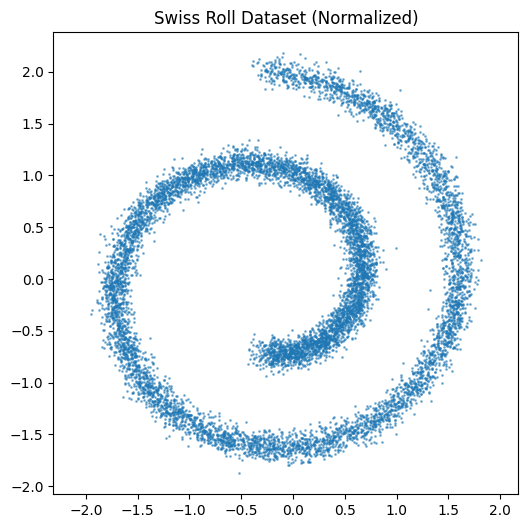

In [2]:
# Generate Swiss Roll data
X, _ = make_swiss_roll(n_samples=10000, noise=0.5, random_state=42)
X = X[:, [0, 2]]  # Use X and Z dimensions
X = (X - X.mean(axis=0)) / X.std(axis=0)  # Normalize to zero mean, unit variance
X = X.astype(np.float32)

print(f"Dataset shape: {X.shape}")
print(f"Mean: {X.mean(axis=0)}, Std: {X.std(axis=0)}")

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], s=1, alpha=0.5)
plt.title('Swiss Roll Dataset (Normalized)')
plt.axis('equal')
plt.show()

## 2. SDE Definitions

In [3]:
class VPSDE:
    """
    Variance Preserving SDE.
    
    Forward SDE: dx = -0.5 * beta(t) * x * dt + sqrt(beta(t)) * dw
    
    Marginal: p(x_t | x_0) = N(alpha(t) * x_0, sigma(t)^2 * I)
    where:
        alpha(t) = exp(-0.5 * integral_0^t beta(s) ds)
        sigma(t) = sqrt(1 - alpha(t)^2)
    """
    def __init__(self, beta_min=0.1, beta_max=20.0, T=1.0):
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.T = T
        self.name = 'VP-SDE'
    
    def beta(self, t):
        """Linear beta schedule."""
        return self.beta_min + t * (self.beta_max - self.beta_min)
    
    def marginal_params(self, t):
        """
        Compute alpha(t) and sigma(t) for the marginal distribution.
        
        Returns: (alpha, sigma) where p(x_t|x_0) = N(alpha*x_0, sigma^2*I)
        """
        # Integral of beta from 0 to t: beta_min*t + 0.5*(beta_max-beta_min)*t^2
        beta_integral = self.beta_min * t + 0.5 * (self.beta_max - self.beta_min) * (t ** 2)
        alpha = torch.exp(-0.5 * beta_integral)
        sigma = torch.sqrt(1 - torch.exp(-beta_integral))
        return alpha, sigma
    
    def diffusion_coeff(self, t):
        """g(t) = sqrt(beta(t))"""
        return torch.sqrt(self.beta(t))
    
    def drift_coeff(self, x, t):
        """f(x, t) = -0.5 * beta(t) * x"""
        return -0.5 * self.beta(t) * x
    
    def prior_sample(self, shape, device):
        """Sample from prior p(x_T) = N(0, I)"""
        return torch.randn(shape, device=device)


class VESDE:
    """
    Variance Exploding SDE.
    
    Forward SDE: dx = sqrt(d[sigma^2]/dt) * dw = sigma(t) * sqrt(2*log(sigma_max/sigma_min)) * dw
    
    Marginal: p(x_t | x_0) = N(x_0, sigma(t)^2 * I)
    where: sigma(t) = sigma_min * (sigma_max/sigma_min)^t
    """
    def __init__(self, sigma_min=0.01, sigma_max=10.0, T=1.0):
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.T = T
        self.name = 'VE-SDE'
    
    def sigma(self, t):
        """Noise level at time t."""
        return self.sigma_min * (self.sigma_max / self.sigma_min) ** t
    
    def marginal_params(self, t):
        """
        Compute alpha(t) and sigma(t) for the marginal distribution.
        
        Returns: (alpha, sigma) where p(x_t|x_0) = N(alpha*x_0, sigma^2*I)
        For VE-SDE: alpha=1, sigma=sigma(t)
        """
        alpha = torch.ones_like(t)
        sigma = self.sigma(t)
        return alpha, sigma
    
    def diffusion_coeff(self, t):
        """g(t) = sigma(t) * sqrt(2 * log(sigma_max/sigma_min))"""
        return self.sigma(t) * math.sqrt(2 * math.log(self.sigma_max / self.sigma_min))
    
    def drift_coeff(self, x, t):
        """f(x, t) = 0 for VE-SDE"""
        return torch.zeros_like(x)
    
    def prior_sample(self, shape, device):
        """Sample from prior p(x_T) = N(0, sigma_max^2 * I)"""
        return torch.randn(shape, device=device) * self.sigma_max


# Create both SDEs
vp_sde = VPSDE(beta_min=0.1, beta_max=20.0, T=1.0)
ve_sde = VESDE(sigma_min=0.01, sigma_max=10.0, T=1.0)

print("Created VP-SDE and VE-SDE")

Created VP-SDE and VE-SDE


## 3. Visualize Forward Process

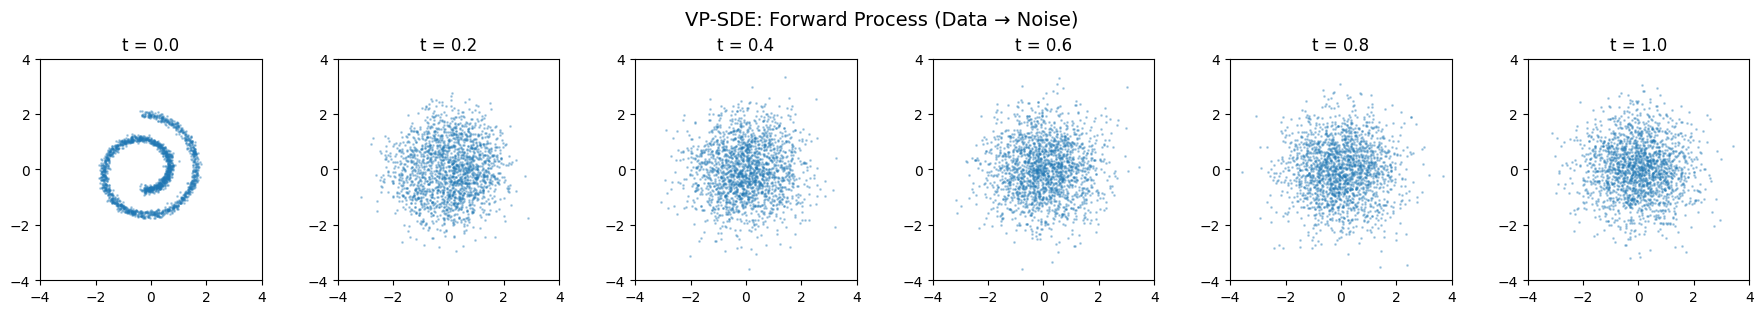

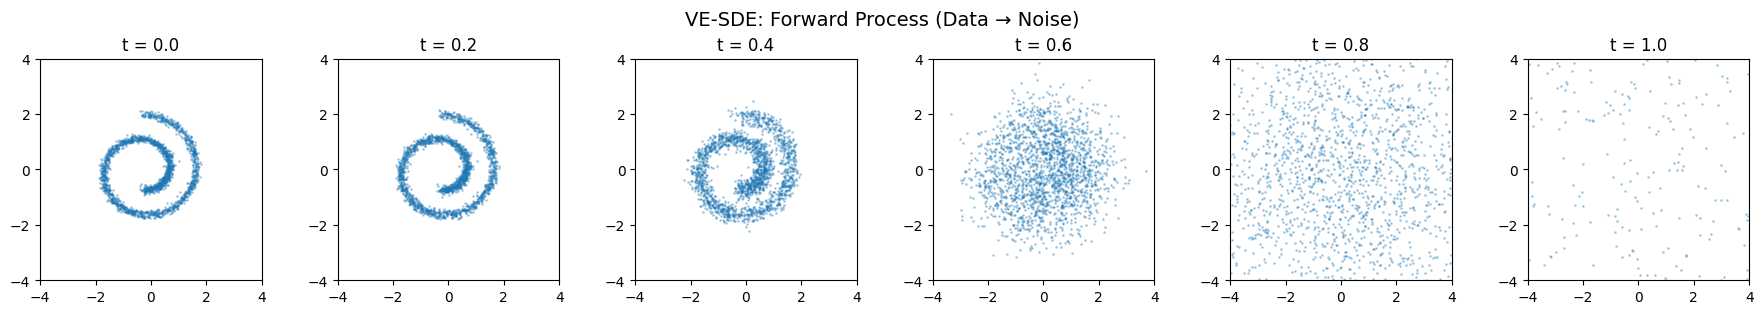

In [4]:
def visualize_forward_sde(sde, data, times=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]):
    """Visualize the forward SDE marginals at different times."""
    fig, axes = plt.subplots(1, len(times), figsize=(18, 3))
    
    x0 = torch.from_numpy(data[:2000])
    
    for idx, t in enumerate(times):
        if t == 0:
            x_t = x0
        else:
            t_tensor = torch.tensor(t)
            alpha, sigma = sde.marginal_params(t_tensor)
            noise = torch.randn_like(x0)
            x_t = alpha * x0 + sigma * noise
        
        axes[idx].scatter(x_t[:, 0].numpy(), x_t[:, 1].numpy(), s=1, alpha=0.3)
        axes[idx].set_title(f't = {t:.1f}')
        axes[idx].set_xlim(-4, 4)
        axes[idx].set_ylim(-4, 4)
        axes[idx].set_aspect('equal')
    
    plt.suptitle(f'{sde.name}: Forward Process (Data → Noise)', fontsize=14)
    plt.tight_layout()
    plt.show()


visualize_forward_sde(vp_sde, X)
visualize_forward_sde(ve_sde, X)

## 4. Time-Conditional Score Network

In [5]:
class ScoreNet(nn.Module):
    """
    Time-conditional score network.
    
    Takes (x, t) and outputs score estimate s(x, t) ≈ ∇_x log p_t(x)
    """
    def __init__(self, data_dim=2, hidden_dim=128, time_embed_dim=16):
        super().__init__()
        
        # Time embedding MLP
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )
        
        # Main network
        self.net = nn.Sequential(
            nn.Linear(data_dim + time_embed_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, data_dim)
        )
    
    def forward(self, x, t):
        """
        Args:
            x: (batch, data_dim)
            t: (batch, 1) with values in [0, T]
        Returns:
            score: (batch, data_dim)
        """
        t_emb = self.time_embed(t)
        h = torch.cat([x, t_emb], dim=-1)
        return self.net(h)


print("ScoreNet defined")

ScoreNet defined


## 5. Training: Denoising Score Matching

For both VP and VE SDEs, the score of the perturbation kernel is:

$$\nabla_{x_t} \log p(x_t | x_0) = -\frac{x_t - \alpha_t x_0}{\sigma_t^2} = -\frac{\epsilon}{\sigma_t}$$

where $x_t = \alpha_t x_0 + \sigma_t \epsilon$ and $\epsilon \sim \mathcal{N}(0, I)$.

In [6]:
def train_score_sde(model, sde, data, epochs=1000, batch_size=256, lr=1e-3, device='cpu'):
    """
    Train score network using denoising score matching.
    
    Loss = E_t E_{x_0} E_{eps} [ ||s_θ(x_t, t) - (-eps/sigma_t)||^2 ]
    """
    dataset = TensorDataset(torch.from_numpy(data))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    
    t_min = 1e-5  # Avoid t=0 for numerical stability
    
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0
        
        for (x_0,) in dataloader:
            x_0 = x_0.to(device)
            batch_size_actual = x_0.shape[0]
            
            # Sample t ~ Uniform(t_min, T)
            t = torch.rand(batch_size_actual, 1, device=device) * (sde.T - t_min) + t_min
            
            # Get marginal parameters
            alpha, sigma = sde.marginal_params(t.squeeze())
            alpha = alpha.unsqueeze(1)  # (batch, 1)
            sigma = sigma.unsqueeze(1)  # (batch, 1)
            
            # Sample x_t from p(x_t | x_0)
            eps = torch.randn_like(x_0)
            x_t = alpha * x_0 + sigma * eps
            
            # Score target: -eps / sigma
            score_target = -eps / sigma
            
            # Predict score
            score_pred = model(x_t, t)
            
            # Loss (can weight by sigma^2 for stability, but simple MSE works here)
            loss = ((score_pred - score_target) ** 2).sum(dim=1).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)
        
        if (epoch + 1) % 100 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:4d}/{epochs} | Loss: {avg_loss:.4f}")
    
    return losses

In [7]:
# Train VP-SDE model
print("Training VP-SDE Score Network...\n")
model_vp = ScoreNet(data_dim=2, hidden_dim=128, time_embed_dim=16).to(device)
losses_vp = train_score_sde(model_vp, vp_sde, X, epochs=1000, lr=1e-3, device=device)

Training VP-SDE Score Network...

Epoch    1/1000 | Loss: 124.8362
Epoch  100/1000 | Loss: 110.2850
Epoch  200/1000 | Loss: 88.2765
Epoch  300/1000 | Loss: 111.8459
Epoch  400/1000 | Loss: 76.4314
Epoch  500/1000 | Loss: 56.9643
Epoch  600/1000 | Loss: 87.8965
Epoch  700/1000 | Loss: 31.8253
Epoch  800/1000 | Loss: 83.1737
Epoch  900/1000 | Loss: 166.3393
Epoch 1000/1000 | Loss: 174.5670


In [8]:
# Train VE-SDE model
print("\nTraining VE-SDE Score Network...\n")
model_ve = ScoreNet(data_dim=2, hidden_dim=128, time_embed_dim=16).to(device)
losses_ve = train_score_sde(model_ve, ve_sde, X, epochs=1000, lr=1e-3, device=device)


Training VE-SDE Score Network...

Epoch    1/1000 | Loss: 1429.5034
Epoch  100/1000 | Loss: 1485.0448
Epoch  200/1000 | Loss: 1442.0779
Epoch  300/1000 | Loss: 1406.1126
Epoch  400/1000 | Loss: 1429.6355
Epoch  500/1000 | Loss: 1412.9677
Epoch  600/1000 | Loss: 1534.2125
Epoch  700/1000 | Loss: 1354.3380
Epoch  800/1000 | Loss: 1440.2873
Epoch  900/1000 | Loss: 1387.6739
Epoch 1000/1000 | Loss: 1389.8508


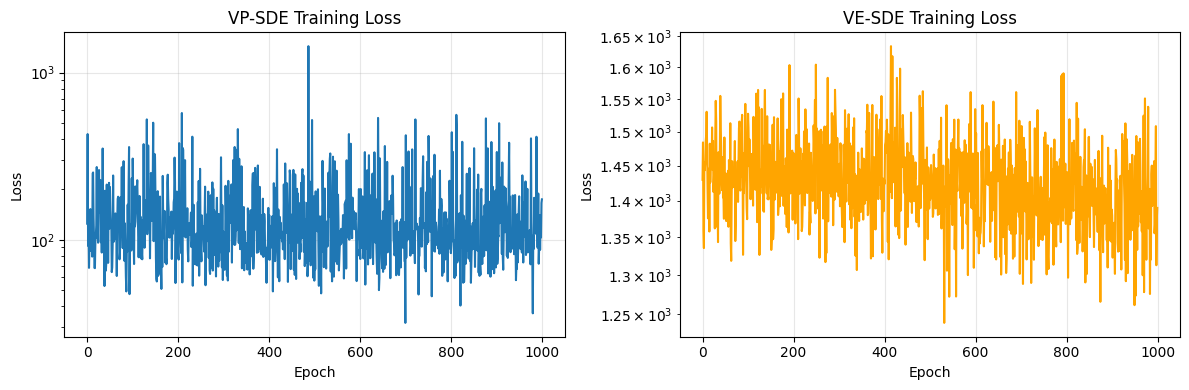

In [9]:
# Plot training losses
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(losses_vp)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('VP-SDE Training Loss')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

axes[1].plot(losses_ve, color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('VE-SDE Training Loss')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Sampling: Reverse SDE with Predictor-Corrector

**Reverse SDE:**
$$dx = \left[ f(x, t) - g(t)^2 s_\theta(x, t) \right] dt + g(t) \, d\bar{w}$$

**Predictor** (Euler-Maruyama on reverse SDE):
$$x_{t-\Delta t} = x_t - \left[ f(x_t, t) - g(t)^2 s_\theta(x_t, t) \right] \Delta t + g(t) \sqrt{\Delta t} \, z$$

**Corrector** (Langevin MCMC):
$$x \leftarrow x + \epsilon \, s_\theta(x, t) + \sqrt{2\epsilon} \, z$$

In [10]:
@torch.no_grad()
def sample_sde(model, sde, n_samples, n_steps=500, corrector_steps=1, 
               corrector_snr=0.1, device='cpu', return_trajectory=False):
    """
    Sample using Predictor-Corrector method.
    
    Args:
        model: Trained score network
        sde: SDE object (VP or VE)
        n_samples: Number of samples
        n_steps: Number of discretization steps
        corrector_steps: Langevin steps per time step
        corrector_snr: Signal-to-noise ratio for corrector
        device: Device
        return_trajectory: Return intermediate samples
    """
    model.eval()
    
    dt = sde.T / n_steps
    
    # Initialize from prior
    x = sde.prior_sample((n_samples, 2), device)
    
    trajectory = [x.cpu().numpy().copy()] if return_trajectory else None
    
    # Time discretization from T to 0
    timesteps = torch.linspace(sde.T, 1e-5, n_steps, device=device)
    
    for i, t in enumerate(timesteps):
        t_batch = t * torch.ones(n_samples, 1, device=device)
        
        # === Corrector (Langevin MCMC) ===
        for _ in range(corrector_steps):
            score = model(x, t_batch)
            
            # Adaptive step size based on score norm
            grad_norm = torch.norm(score.view(n_samples, -1), dim=-1).mean()
            step_size = (corrector_snr / grad_norm) ** 2 * 2
            step_size = min(step_size.item(), 0.1)  # Clip for stability
            
            noise = torch.randn_like(x)
            x = x + step_size * score + math.sqrt(2 * step_size) * noise
        
        # === Predictor (Reverse SDE Euler-Maruyama) ===
        score = model(x, t_batch)
        
        # Get SDE coefficients
        f = sde.drift_coeff(x, t)
        g = sde.diffusion_coeff(t)
        
        # Reverse drift: f - g^2 * score
        reverse_drift = f - (g ** 2) * score
        
        # Euler-Maruyama step
        noise = torch.randn_like(x) if i < n_steps - 1 else 0
        x = x - reverse_drift * dt + g * math.sqrt(dt) * noise
        
        if return_trajectory and (i % (n_steps // 10) == 0 or i == n_steps - 1):
            trajectory.append(x.cpu().numpy().copy())
    
    if return_trajectory:
        return x.cpu().numpy(), trajectory
    return x.cpu().numpy()

In [11]:
# Generate samples from both models
print("Generating VP-SDE samples...")
samples_vp, traj_vp = sample_sde(model_vp, vp_sde, n_samples=5000, n_steps=500, 
                                  corrector_steps=1, corrector_snr=0.1,
                                  device=device, return_trajectory=True)

print("Generating VE-SDE samples...")
samples_ve, traj_ve = sample_sde(model_ve, ve_sde, n_samples=5000, n_steps=500,
                                  corrector_steps=1, corrector_snr=0.1,
                                  device=device, return_trajectory=True)

print("Done!")

Generating VP-SDE samples...
Generating VE-SDE samples...
Done!


## 7. Results

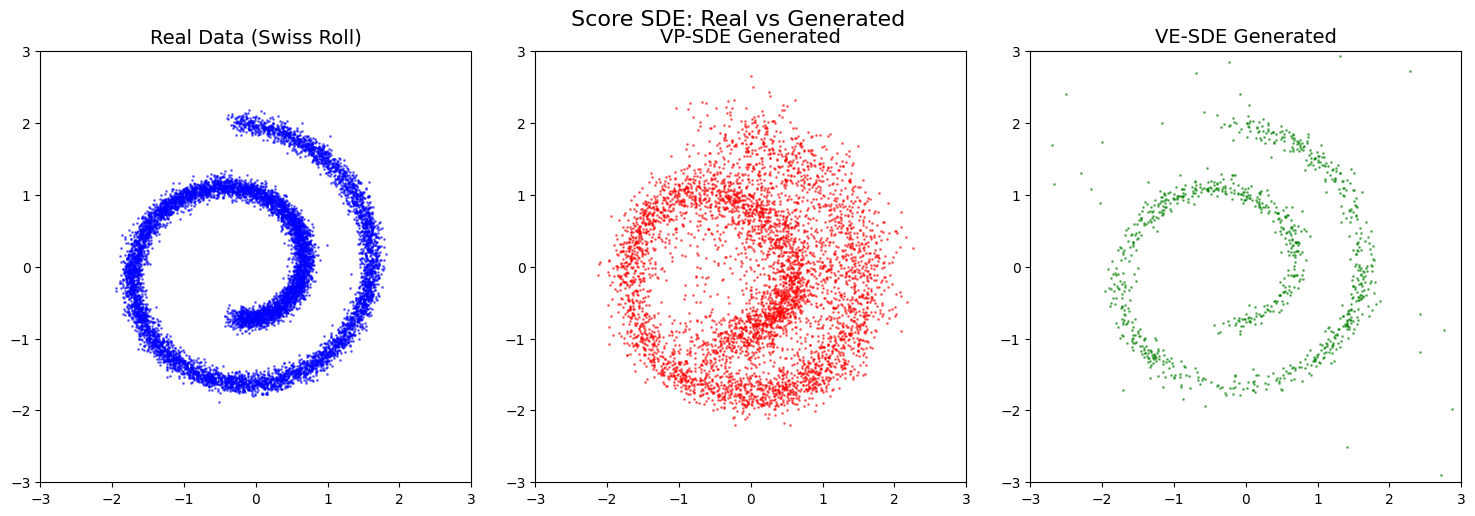

In [12]:
# Compare real vs generated for both SDEs
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(X[:, 0], X[:, 1], s=1, alpha=0.5, c='blue')
axes[0].set_title('Real Data (Swiss Roll)', fontsize=14)
axes[0].set_xlim(-3, 3)
axes[0].set_ylim(-3, 3)
axes[0].set_aspect('equal')

axes[1].scatter(samples_vp[:, 0], samples_vp[:, 1], s=1, alpha=0.5, c='red')
axes[1].set_title('VP-SDE Generated', fontsize=14)
axes[1].set_xlim(-3, 3)
axes[1].set_ylim(-3, 3)
axes[1].set_aspect('equal')

axes[2].scatter(samples_ve[:, 0], samples_ve[:, 1], s=1, alpha=0.5, c='green')
axes[2].set_title('VE-SDE Generated', fontsize=14)
axes[2].set_xlim(-3, 3)
axes[2].set_ylim(-3, 3)
axes[2].set_aspect('equal')

plt.suptitle('Score SDE: Real vs Generated', fontsize=16)
plt.tight_layout()
plt.show()

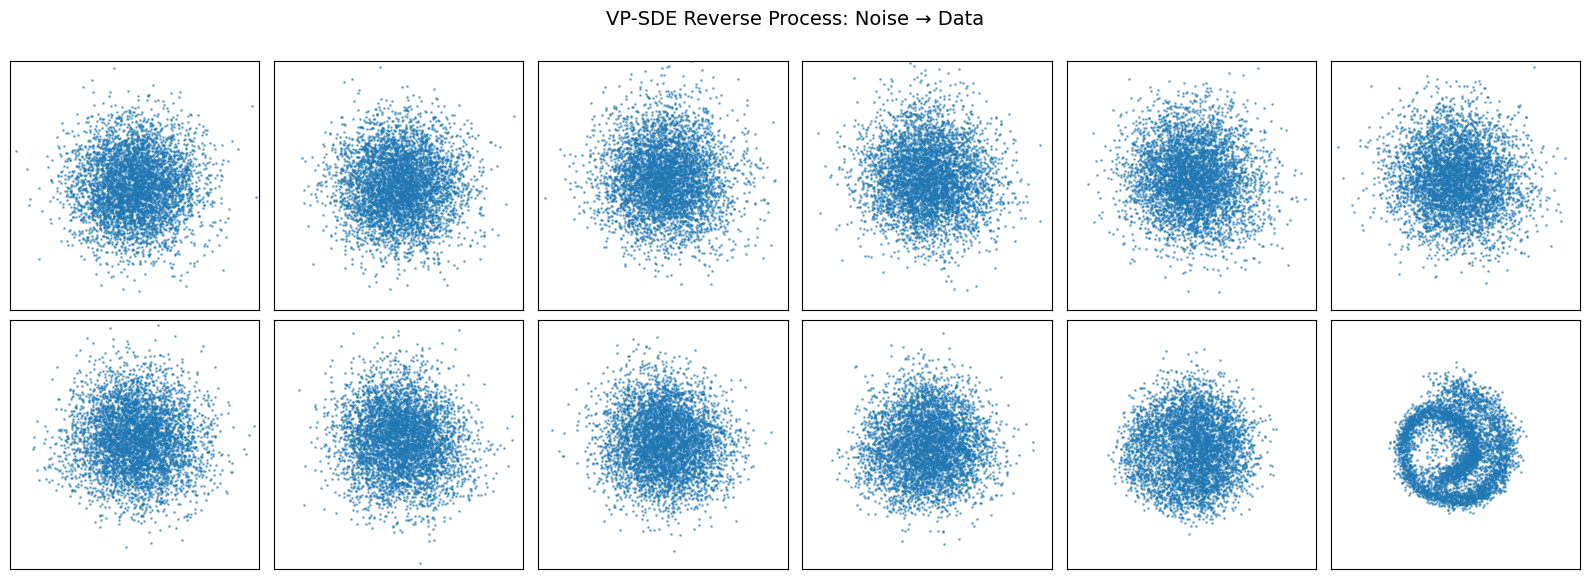

In [13]:
# Visualize VP-SDE reverse trajectory
n_show = len(traj_vp)
fig, axes = plt.subplots(2, (n_show + 1) // 2, figsize=(16, 6))
axes = axes.flatten()

for idx, data in enumerate(traj_vp):
    axes[idx].scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
    axes[idx].set_xlim(-4, 4)
    axes[idx].set_ylim(-4, 4)
    axes[idx].set_aspect('equal')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

for idx in range(len(traj_vp), len(axes)):
    axes[idx].axis('off')

plt.suptitle('VP-SDE Reverse Process: Noise → Data', fontsize=14)
plt.tight_layout()
plt.show()

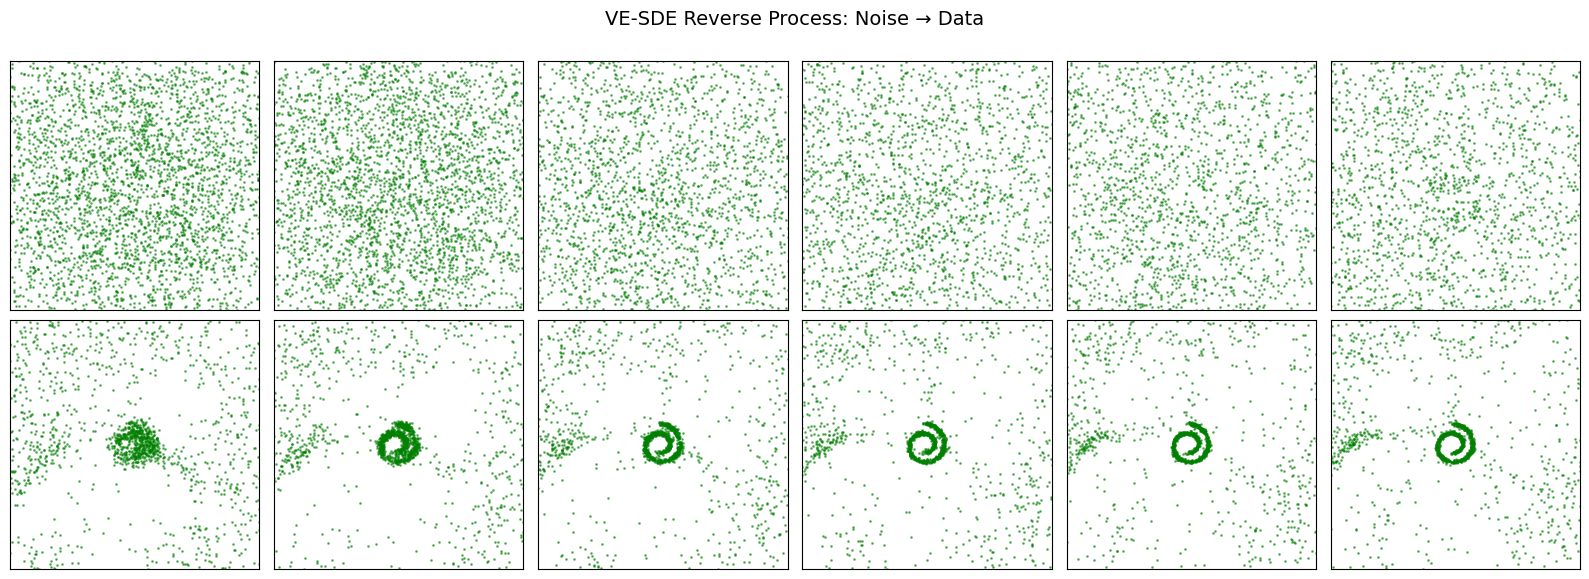

In [14]:
# Visualize VE-SDE reverse trajectory
n_show = len(traj_ve)
fig, axes = plt.subplots(2, (n_show + 1) // 2, figsize=(16, 6))
axes = axes.flatten()

for idx, data in enumerate(traj_ve):
    axes[idx].scatter(data[:, 0], data[:, 1], s=1, alpha=0.5, c='green')
    axes[idx].set_xlim(-12, 12)
    axes[idx].set_ylim(-12, 12)
    axes[idx].set_aspect('equal')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

for idx in range(len(traj_ve), len(axes)):
    axes[idx].axis('off')

plt.suptitle('VE-SDE Reverse Process: Noise → Data', fontsize=14)
plt.tight_layout()
plt.show()

## 8. Summary

We implemented both **VP-SDE** and **VE-SDE** for Score-based generative modeling:

### VP-SDE (Variance Preserving)
- Forward: $dx = -\frac{1}{2}\beta(t) x \, dt + \sqrt{\beta(t)} \, dw$
- Marginal: $x_t = \alpha_t x_0 + \sigma_t \epsilon$ where $\alpha_t = e^{-\frac{1}{2}\int_0^t \beta(s)ds}$
- Prior: $\mathcal{N}(0, I)$
- **Continuous-time DDPM**

### VE-SDE (Variance Exploding)
- Forward: $dx = \sqrt{\frac{d[\sigma^2]}{dt}} \, dw$
- Marginal: $x_t = x_0 + \sigma_t \epsilon$ where $\sigma_t = \sigma_{min}(\sigma_{max}/\sigma_{min})^t$
- Prior: $\mathcal{N}(0, \sigma_{max}^2 I)$
- **Continuous-time NCSN**

### Key Components
1. **Time-conditional score network** $s_\theta(x, t)$
2. **Denoising score matching** loss
3. **Predictor-Corrector** sampling (reverse SDE + Langevin MCMC)